Extracting features and normalizing...
Starting Training: 201 samples...
Epoch 05 | Train Loss: 0.2997 | Val Acc: 86.05%
Epoch 10 | Train Loss: 0.2596 | Val Acc: 100.00%
Epoch 15 | Train Loss: 0.2305 | Val Acc: 100.00%
Epoch 20 | Train Loss: 0.2258 | Val Acc: 100.00%
Epoch 25 | Train Loss: 0.2268 | Val Acc: 100.00%
Epoch 30 | Train Loss: 0.2185 | Val Acc: 100.00%
Epoch 35 | Train Loss: 0.2181 | Val Acc: 100.00%
Epoch 40 | Train Loss: 0.2203 | Val Acc: 100.00%
Epoch 45 | Train Loss: 0.2129 | Val Acc: 100.00%
Epoch 50 | Train Loss: 0.2134 | Val Acc: 100.00%

--- FINAL TEST RESULTS ---
Accuracy: 97.73%
              precision    recall  f1-score   support

        Good       0.97      1.00      0.99        35
         Bad       1.00      0.89      0.94         9

    accuracy                           0.98        44
   macro avg       0.99      0.94      0.96        44
weighted avg       0.98      0.98      0.98        44



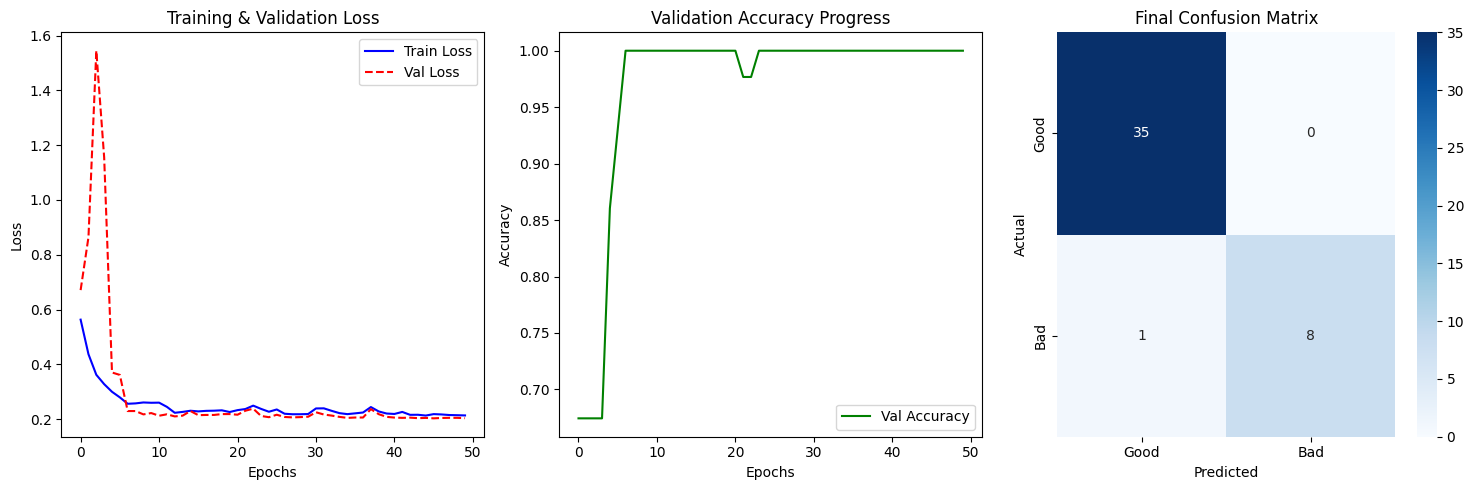

In [3]:
import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# ============================================================================
# CONFIG
# ============================================================================
VIDEO_DIR = r"C:\Users\PRASHANTH\gcn"
SEQ_LEN = 30
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-3

ADJ = [
    (0,1),(0,2),(1,3),(2,4), (5,6),(5,7),(7,9),(6,8),(8,10),
    (11,12),(11,13),(13,15),(12,14),(14,16), (5,11),(6,12)
]

def get_adj_matrix():
    A = np.eye(17)
    for i, j in ADJ:
        A[i, j] = A[j, i] = 1
    D = np.diag(np.sum(A, axis=1)**-0.5)
    A_norm = D @ A @ D
    return torch.FloatTensor(A_norm)

# ============================================================================
# AUGMENTATION & PREPROCESSING
# ============================================================================
class SkeletonUtils:
    @staticmethod
    def normalize(coords):
        for i in range(len(coords)):
            mid_hip = (coords[i, 11, :] + coords[i, 12, :]) / 2
            coords[i] -= mid_hip
        return coords

    @staticmethod
    def add_noise(x, sigma=0.005):
        if torch.rand(1) > 0.5:
            noise = torch.randn_like(x) * sigma
            return x + noise
        return x

# ============================================================================
# SQUAT PROCESSOR
# ============================================================================
class SquatProcessor:
    def __init__(self):
        self.pose = mp.solutions.pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
    
    def get_si(self, l, r):
        return (abs(l - r) / (0.5 * (l + r) + 1e-6)) * 100

    def process_video(self, path):
        cap = cv2.VideoCapture(path)
        coords, labels = [], []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret: break
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = self.pose.process(img)
            if res.pose_landmarks:
                pts = [[lm.x, lm.y] for lm in res.pose_landmarks.landmark[:17]]
                coords.append(pts)
                k_si = self.get_si(pts[13][1], pts[14][1])
                h_si = self.get_si(pts[11][1], pts[12][1])
                labels.append(1 if (k_si > 10 or h_si > 10) else 0)
        cap.release()
        if len(coords) < SEQ_LEN: return None, None
        
        coords = SkeletonUtils.normalize(np.array(coords))
        final_label = 1 if np.mean(labels) > 0.4 else 0
        return coords, final_label

# ============================================================================
# CTR-GCN MODEL
# ============================================================================
class CTR_GC(nn.Module):
    def __init__(self, in_c, out_c, adj):
        super().__init__()
        self.adj = nn.Parameter(adj, requires_grad=False)
        self.refine = nn.Conv2d(in_c, out_c, 1)
        self.pa = nn.Parameter(torch.randn(out_c, 17, 17) * 0.02)
        self.alpha = nn.Parameter(torch.ones(1)) 

    def forward(self, x):
        x = self.refine(x)
        A = self.alpha * self.adj.unsqueeze(0) + self.pa
        x = torch.einsum('bctv,cvw->bctw', x, A)
        return x

class CTRGCN_Block(nn.Module):
    def __init__(self, in_c, out_c, adj, stride=1):
        super().__init__()
        self.gcn = CTR_GC(in_c, out_c, adj)
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, (9, 1), (stride, 1), (4, 0)),
            nn.BatchNorm2d(out_c)
        )
        self.res = nn.Conv2d(in_c, out_c, 1) if in_c != out_c else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.tcn(self.gcn(x)) + self.res(x))

class CTRGCN(nn.Module):
    def __init__(self):
        super().__init__()
        adj = get_adj_matrix()
        self.layer1 = CTRGCN_Block(2, 64, adj)
        self.layer2 = CTRGCN_Block(64, 32, adj)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

# ============================================================================
# EVALUATION & MAIN
# ============================================================================
def evaluate(model, loader, device, criterion=None):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if criterion:
                loss = criterion(output, target)
                total_loss += loss.item()
            all_preds.extend(torch.argmax(output, 1).cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    avg_loss = total_loss / len(loader) if criterion else 0
    return accuracy_score(all_labels, all_preds), avg_loss, all_labels, all_preds

def main():
    proc = SquatProcessor()
    videos = glob.glob(os.path.join(VIDEO_DIR, "*.mp4"))
    X, y = [], []
    
    print("Extracting features and normalizing...")
    for v in videos:
        coords, label = proc.process_video(v)
        if coords is not None:
            for i in range(0, len(coords) - SEQ_LEN, 5):
                X.append(coords[i:i+SEQ_LEN].transpose(2, 0, 1))
                y.append(label)

    X = torch.FloatTensor(np.array(X))
    y = torch.LongTensor(np.array(y))
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    train_loader = DataLoader(list(zip(X_train, y_train)), BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(list(zip(X_val, y_val)), BATCH_SIZE)
    test_loader = DataLoader(list(zip(X_test, y_test)), BATCH_SIZE)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CTRGCN().to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # History tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_acc = 0
    print(f"Starting Training: {len(X_train)} samples...")
    for epoch in range(EPOCHS):
        model.train()
        epoch_train_loss = 0
        for data, target in train_loader:
            data = SkeletonUtils.add_noise(data)
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        # Log metrics every epoch for graphing
        avg_train_loss = epoch_train_loss / len(train_loader)
        val_acc, avg_val_loss, _, _ = evaluate(model, val_loader, device, criterion)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2%}")
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), "best_squat_ctrgcn.pt")

    # Final Evaluation
    print("\n--- FINAL TEST RESULTS ---")
    model.load_state_dict(torch.load("best_squat_ctrgcn.pt"))
    test_acc, _, y_true, y_pred = evaluate(model, test_loader, device)
    print(f"Accuracy: {test_acc:.2%}")
    print(classification_report(y_true, y_pred, target_names=['Good', 'Bad']))

    # ============================================================================
    # VISUALIZATION GRAPHS
    # ============================================================================
    plt.figure(figsize=(15, 5))

    # Plot 1: Loss Curve
    plt.subplot(1, 3, 1)
    
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot 2: Accuracy Curve
    plt.subplot(1, 3, 2)
    
    plt.plot(history['val_acc'], label='Val Accuracy', color='green')
    plt.title('Validation Accuracy Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot 3: Confusion Matrix
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
    plt.title('Final Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()